In [26]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import numpy
import csv

In [41]:
data = []
column_names = []
with open('BeachHouse.csv') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0:
            column_names = row
        else:
            data.append(row)

def to_datetime(date):
    return datetime.strptime(date, "%m/%d/%Y %I:%M:%S %p")
    
data = sorted(data, key=lambda r: to_datetime(r[0]));

In [43]:
print(column_names)
[x[0] for x in data[:10]]

['Date/Time', 'Lot', 'Description', 'Address', 'Zip', 'Latitude', 'Longitude', 'Available', 'Map Point']


['11/01/2017 12:00:00 AM',
 '11/01/2017 12:05:00 AM',
 '11/01/2017 12:10:00 AM',
 '11/01/2017 12:15:00 AM',
 '11/01/2017 12:20:00 AM',
 '11/01/2017 12:25:00 AM',
 '11/01/2017 12:30:00 AM',
 '11/01/2017 12:35:00 AM',
 '11/01/2017 12:40:00 AM',
 '11/01/2017 12:45:00 AM']

In [44]:
datetimes = [to_datetime(x[0]) for x in data]
open_spots = [int(x[7]) for x in data]

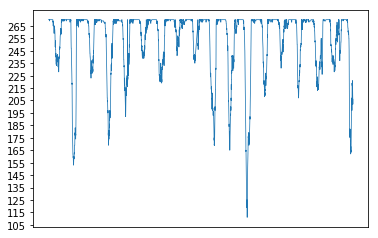

In [46]:
#print(dates[:10])
#print(open_spots[:10])

plt.yticks(np.arange(min(open_spots), max(open_spots)+1, 10))
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.plot(datetimes[:5000],open_spots[:5000], linewidth=0.75)
plt.show()
#plt.gcf().autofmt_xdate()


In [47]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [63]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [137]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
float_dates = [matplotlib.dates.date2num(date) for date in datetimes]
open_spots = np.array(open_spots)
open_spots = open_spots.reshape(open_spots.shape[0], -1)
dataset = scaler.fit_transform(open_spots[:10000])
dataset = dataset.astype('float32')

In [138]:
# split into train and test sets
train_size = int(len(dataset) * 0.10)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(1000, 9000)


In [139]:
# load the dataset
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
#dataset = dataframe.values
#dataset = dataset.astype('float32')
##print(dataframe)
#print(dataset)

In [140]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [141]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [142]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [143]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 4s - loss: 0.0790
Epoch 2/10
 - 3s - loss: 0.0036
Epoch 3/10
 - 3s - loss: 0.0020
Epoch 4/10
 - 4s - loss: 7.4166e-04
Epoch 5/10
 - 3s - loss: 1.8446e-04
Epoch 6/10
 - 3s - loss: 9.0862e-05
Epoch 7/10
 - 3s - loss: 8.6404e-05
Epoch 8/10
 - 4s - loss: 8.8994e-05
Epoch 9/10
 - 3s - loss: 9.4494e-05
Epoch 10/10
 - 4s - loss: 8.8640e-05


In [156]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# TODO: TRY model.forecast

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
new_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
new_testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(new_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(new_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.14 RMSE
Test Score: 2.97 RMSE


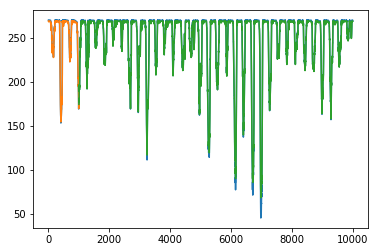

In [163]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

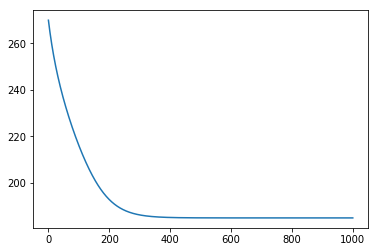

In [219]:
predictions = [testX[-1]]
for i in range(1000):
    next_val = model.predict(np.array([predictions[-1]])) 
    #print(next_val)
    predictions.append(next_val)
new_predictions = [p[0] for p in predictions]
plt.plot(scaler.inverse_transform(new_predictions))

In [220]:
#####################
#     ATTEMPT 2     #
#####################

In [ ]:
import pandas as pd
from pandas.tseries.offsets import *
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

csv_file = 'analyse vtr.csv'
df = pd.read_csv(csv_file, index_col=[0], sep='\t')
grouped = df.groupby('adserver_id')
group = list(grouped)[0][1]
print(group)

ts_data = pd.Series(group.c_start.values, index=pd.to_datetime(group.day))
# positive-valued process, looks non-stationary
# simple way is to do a log transform
fig, axes = plt.subplots(figsize=(10,8), nrows=3)
ts_data.plot(ax=axes[0])

ts_log_data = np.log(ts_data)
ts_log_data.plot(ax=axes[1], style='b-', label='actual')

# in-sample fit
# ===================================
model = sm.tsa.ARMA(ts_log_data, order=(1,1)).fit()
print(model.params)

y_pred = model.predict(ts_log_data.index[0].isoformat(), ts_log_data.index[-1].isoformat())
y_pred.plot(ax=axes[1], style='r--', label='in-sample fit')

y_resid = model.resid
y_resid.plot(ax=axes[2])

# out-sample predict
# ===================================
start_date = ts_log_data.index[-1] + Day(1)
end_date = ts_log_data.index[-1] + Day(7)

y_forecast = model.predict(start_date.isoformat(), end_date.isoformat())

print(y_forecast)

# NOTE: this step introduces bias, it is used here just for simplicity
# E[exp(x)] != exp[E[x]]
print(np.exp(y_forecast))

In [117]:
csv_file = 'BeachHouse.csv'
df = pd.read_csv(csv_file, sep=',')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df = df.sort_values('Date/Time')
#print(df)
ts_data = pd.Series(df['Available'].values, index=pd.to_datetime(df['Date/Time']))

const      255.175385
ar.L1.y      0.995700
ma.L1.y      0.073838
dtype: float64


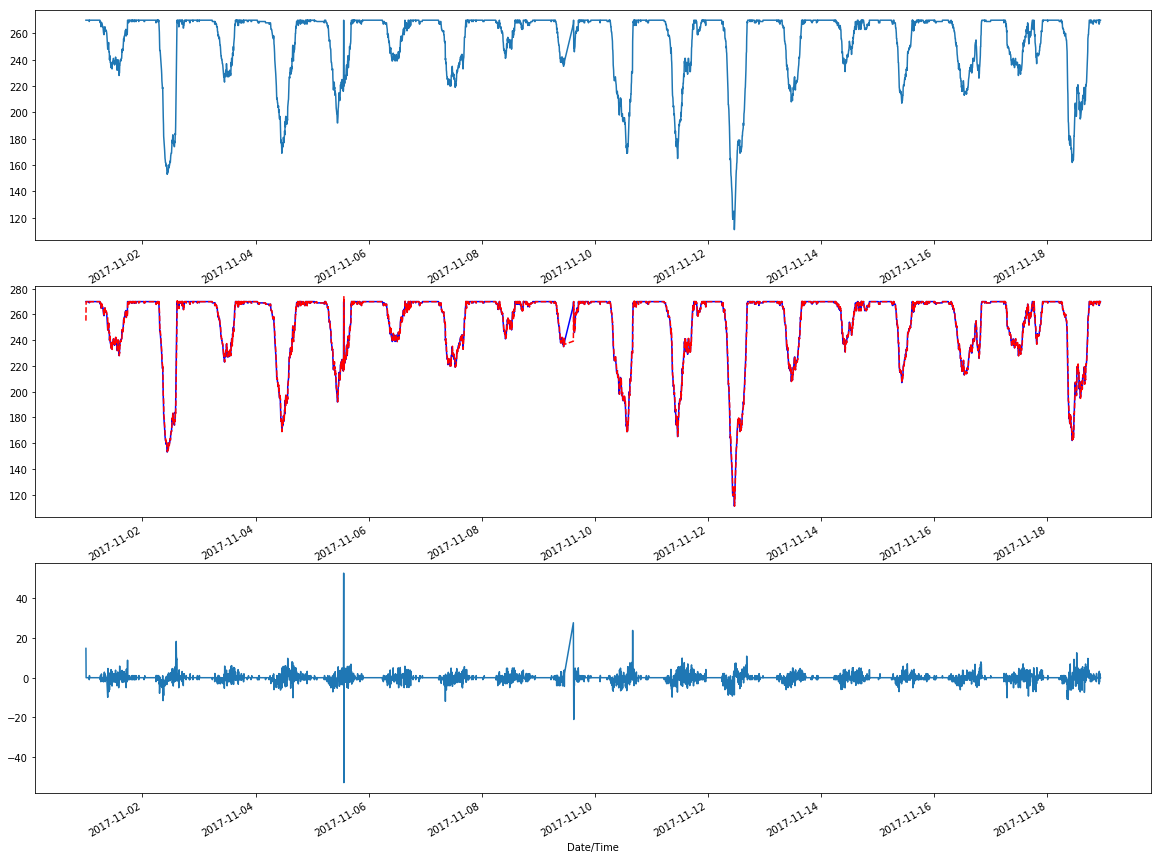

In [129]:
# positive-valued process, looks non-stationary
# simple way is to do a log transform
fig, axes = plt.subplots(figsize=(20,16), nrows=3)
ts_data = ts_data.astype('float64')
new_ts_data = ts_data.take(np.arange(5100))
new_ts_data.plot(ax=axes[0])

#print(new_ts_data)
new_ts_data.plot(ax=axes[1], style='b-', label='actual')

# in-sample fit
# ===================================
model = sm.tsa.ARMA(new_ts_data, order=(1,1)).fit()
print(model.params)

y_pred = model.predict(new_ts_data.index[0].isoformat(), new_ts_data.index[-1].isoformat())
y_pred.plot(ax=axes[1], style='r--', label='in-sample fit')

y_resid = model.resid
y_resid.plot(ax=axes[2])

<class 'statsmodels.tsa.arima_model.ARMAResultsWrapper'>
[269.94063761 269.87714221 269.81391985 269.75096937 269.6882896
 269.62587937 269.56373753 269.50186291 269.44025438 269.37891079
 269.31783099 269.25701385 269.19645825 269.13616306 269.07612715
 269.01634942 268.95682876 268.89756405 268.8385542  268.77979811
 268.72129469 268.66304286 268.60504153 268.54728962 268.48978606
 268.43252979 268.37551974 268.31875485 268.26223407 268.20595634
 268.14992063 268.09412589 268.03857109 267.98325519 267.92817717
 267.873336   267.81873066 267.76436015 267.71022344 267.65631954
 267.60264745 267.54920617 267.49599469 267.44301205 267.39025725
 267.33772931 267.28542726 267.23335012 267.18149693 267.12986673
 267.07845856 267.02727146 266.97630447 266.92555667 266.87502709
 266.82471481 266.77461889 266.7247384  266.67507241 266.62561999
 266.57638025 266.52735224 266.47853508 266.42992784 266.38152963
 266.33333955 266.2853567  266.2375802  266.19000915 266.14264267
 266.09547988 266.04

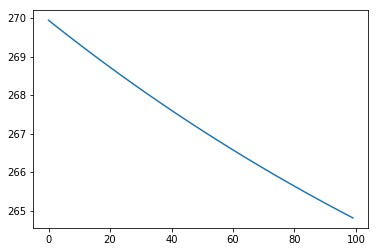

In [130]:

# out-sample predict
# ===================================
start_date = new_ts_data.index[-1] - Day(7)
end_date = new_ts_data.index[-1]

print(type(model))
y_forecast, stderr, conf_int = model.forecast(steps=100)

print(y_forecast)
print(stderr)

plt.plot(y_forecast)

# NOTE: this step introduces bias, it is used here just for simplicity
# E[exp(x)] != exp[E[x]]
#print(np.exp(y_forecast))